![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Responsible AI - Final Project Solution</a>

Build a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) that predicts the __credit_risk__ field (whether some is a credit risk or not) of the [German Credit Dataset](https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29).

### Final Project Problem: Loan Approval

__Problem Definition:__
Given a set of features about an individual (e.g. age, past credit history, immigration status, ...) predict whether a loan is repaid or not (is customer a credit risk). We impose the additional constraint that the model should be fair with respect to different age groups ($\geq$ 25 yrs and $<$ 25 yrs).

In the banking industry, there are certain regulations regarding the use of sensitive features (e.g., age, ethnicity, marital status, ...). According to those regulations, it would not be okay if age played a significant role in the model (loans should be approved/denied regardless of an individuals' age).

For example, certain laws declare it unlawful for creditors to discriminate against any applicant on the basis of age (or other sensitive attributes). For more details, have a look at this paper:

``` 
F. Kamiran and T. Calders, "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012
```

__Table of contents__

1. <a href="#1">Read the datasets</a> (Given) 
2. <a href="#2">Data Processing</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a> (Suggested)
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data Processing with Pipeline</a>
3. <a href="#3">Train (and Tune) a Classifier on the Training Dataset</a> (Implement)
4. <a href="#4">Make Predictions on the Test Dataset</a> (Implement)
5. <a href="#5">Evaluate Results</a> (Given)


__Datasets and Files__


- ```german_credit_training.csv```: Training data with loan applicants features, credit history, dependents, savings, account status, age group (and more). The label is __credit_risk__.

- ```german_credit_test.csv```: Test data with same features as above apart from label. This will be the data to make predictions for to emulate a production environment.

This notebook assumes an installation of the SageMaker kernel `conda_pytorch_p39`. In addition, libraries from a requirements.txt need to be installed:

In [1]:
!pip install --no-deps -U -q -r ../../requirements.txt

In [2]:
# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
import sys

sys.path.append("..")

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Then, we read the __training__ and __test__ datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). This library allows us to read and manipulate our data.

In [3]:
training_data = pd.read_csv("../../data/final_project/german_credit_training.csv")
test_data = pd.read_csv("../../data/final_project/german_credit_test.csv")

print("The shape of the training dataset is:", training_data.shape)
print("The shape of the test dataset is:", test_data.shape)

The shape of the training dataset is: (800, 24)
The shape of the test dataset is: (200, 23)


## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>) 

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [4]:
training_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,credit_risk,age_groups
0,564,male,married/widowed,... < 0 DM,24,existing credits paid back duly till now,retraining,4712,.. >= 1000 DM,1 <= ... < 4 years,...,37,bank,rent,2-3,management/self-employed/highly qualified empl...,0 to 2,True,False,0,1
1,484,male,married/widowed,... >= 200 DM,12,all credits at this bank paid back duly,others,1163,100 <= ... < 500 DM,1 <= ... < 4 years,...,44,none,rent,1,skilled employee/official,0 to 2,True,False,0,1
2,26,female,single,... >= 200 DM,6,delay in paying off in the past,furniture/equipment,426,unknown/no savings account,.. >= 7 years,...,39,none,rent,1,unskilled - resident,0 to 2,False,False,0,1
3,443,male,married/widowed,... >= 200 DM,12,no credits taken/all credits paid back duly,repairs,719,unknown/no savings account,.. >= 7 years,...,41,bank,rent,1,unskilled - resident,3 or more,False,False,1,1
4,211,female/male,female (non-single) or male (single),... >= 200 DM,36,no credits taken/all credits paid back duly,furniture/equipment,3835,.. >= 1000 DM,.. >= 7 years,...,45,none,rent,1,unskilled - resident,0 to 2,True,False,0,1


In [5]:
test_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,property,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,age_groups
0,963,male,married/widowed,... >= 200 DM,24,no credits taken/all credits paid back duly,furniture/equipment,2397,100 <= ... < 500 DM,.. >= 7 years,...,building society savings agreement/life insurance,35,bank,rent,2-3,skilled employee/official,0 to 2,True,False,1
1,611,female/male,female (non-single) or male (single),0 <= ... < 200 DM,10,no credits taken/all credits paid back duly,others,1240,... < 100 DM,.. >= 7 years,...,real estate,48,none,own,1,unskilled - resident,3 or more,False,False,1
2,106,male,married/widowed,... >= 200 DM,18,critical account/other credits existing (not a...,others,6458,unknown/no savings account,.. >= 7 years,...,real estate,39,bank,rent,2-3,management/self-employed/highly qualified empl...,3 or more,True,False,1
3,891,male,married/widowed,... >= 200 DM,15,all credits at this bank paid back duly,furniture/equipment,1829,unknown/no savings account,.. >= 7 years,...,building society savings agreement/life insurance,46,none,rent,2-3,skilled employee/official,0 to 2,True,False,1
4,342,female,single,... < 0 DM,18,no credits taken/all credits paid back duly,furniture/equipment,3213,100 <= ... < 500 DM,... < 1 year,...,unknown/no property,25,none,for free,1,skilled employee/official,0 to 2,False,False,1


In [6]:
# Implement more EDA here

In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        800 non-null    int64 
 1   sex                       800 non-null    object
 2   personal_status           800 non-null    object
 3   checking_account_status   800 non-null    object
 4   credit_duration_months    800 non-null    int64 
 5   credit_history            800 non-null    object
 6   credit_purpose            800 non-null    object
 7   credit_amount             800 non-null    int64 
 8   savings                   800 non-null    object
 9   employed_since_years      800 non-null    object
 10  installment_rate          800 non-null    object
 11  other_debtors_guarantors  800 non-null    object
 12  present_residence_since   800 non-null    object
 13  property                  800 non-null    object
 14  age_years                 

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Data Processing</a>)

For a quick start, we recommend using only a few of the numerical and categorical features. However, feel free to explore other fields. In this case, we do not need to cast our features to numerical/objects. Mindful with some of the feature names - they suggest numerical values but upon inspection it should become clear that they are actually categoricals (e.g. `employed_since_years` has been binned into groups).


In [8]:
# Grab model features/inputs and target/output
categorical_features = ["job_status", "employed_since_years", "savings", "age_groups"]

numerical_features = ["credit_amount", "credit_duration_months"]

Separate features and the model target.

In [9]:
model_target = "credit_risk"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['job_status', 'employed_since_years', 'savings', 'age_groups', 'credit_amount', 'credit_duration_months']
Model target:  credit_risk


### 2.3 <a name="23">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, but no validation dataset (which you need to create). Furthermore, the test dataset is missing the labels - the goal of the project is to predict these labels. 

To produce a validation set to evaluate model performance, split the training dataset into train and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Validation data you get here will be used later in section 3 to tune your classifier.

In [10]:
# Implement here

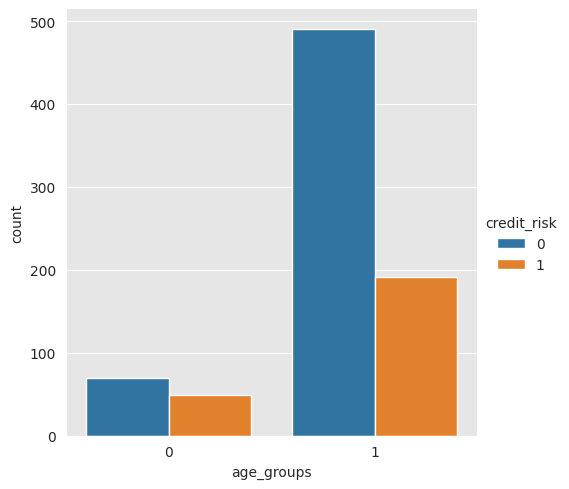

In [11]:
sns.catplot(x="age_groups", hue="credit_risk", kind="count", data=training_data)

We observe that age group with members that are less than 25 yrs old are at a disadvantage. Almost the same number of applications get rejected as approved whereas for the group with members $\geq$ the ration is almost 3:1 (e.g. three times as many applications approved as rejected).

In [12]:
# We only need to split between train and val (test is already separate)
train_data, val_data = train_test_split(
    training_data, test_size=0.1, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation datasets shapes:  (720, 24) (200, 23) (80, 24)


### 2.4 <a name="24">Data processing with Pipeline</a>
(<a href="#2">Go to Data Processing</a>)

Build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to impute the missing values and scale the numerical features, and finally train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  on the imputed and scaled dataset. 


In [13]:
# Implement here

In [14]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)

### STEP 3 ###
##############

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(solver="lbfgs", penalty="none")),
    ]
)

## 3. <a name="3">Train (and Tune) a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train (and tune) the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pipeline. For tuning, you can try different imputation strategies, different scaling methods.

In [15]:
# Implement here

In [16]:
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline is imputed (with means from the train data),
#   scaled (with the min/max from the train data),
#   and finally used to fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['credit_amount',
                                                   'credit_duration_months']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['job_status',
                                                   'employed_since_years',
                                                   'savings',
                                                   'age_groups'])])),
                ('lg', LogisticRegression(penalty='none'))])

## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to predict the labels on the test set. Below you will find a code snippet that evaluates for DI.

In [17]:
# Implement here

# Get test data to test the classifier
# ! test data should come from german_credit_test.csv !
# ...

# Use the trained model to make predictions on the test dataset
# test_predictions = ...

In [18]:
# Get test data to validate the classifier
X_test = test_data[model_features]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline is imputed (with means from the train data),
#   scaled (with the min/max from the train data),
#   and finally used to make predictions
test_predictions = pipeline.predict(X_test)

## 5. <a name="5">Evaluate Results</a> (Given)
(<a href="#0">Go to top</a>)

In [19]:
result_df = pd.DataFrame(columns=["ID", "credit_risk_pred"])
result_df["ID"] = test_data["ID"].tolist()
result_df["credit_risk_pred"] = test_predictions

result_df.to_csv("../../data/final_project/project_day1_result.csv", index=False)

### Final Evaluation on Test Data - Disparate Impact
To evaluate the fairness of the model predictions, we will calculate the disparate impact (DI) metric. For more details about DI you can have a look [here](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-post-training-bias-metric-di.html).

In [20]:
def calculate_di(test_data, pred_df, pred_col="credit_risk_pred"):
    """
    Function to calculate Disparate Impact metric using the results from this notebook.
    """
    try:
        # Merge predictions with original test data to model per group
        di_df = pred_df.merge(test_data, on="ID")
        # Count for group with members less than 25y old
        pos_outcomes_less25 = di_df[di_df["age_groups"] == 0][pred_col].value_counts()[
            0
        ]  # value_counts()[0] takes the count of the '0 credit risk' == 'not credit risk'
        total_less25 = len(di_df[di_df["age_groups"] == 0])
        # Count for group with members greater equal 25y old
        pos_outcomes_geq25 = di_df[di_df["age_groups"] == 1][pred_col].value_counts()[
            0
        ]  # value_counts()[0] takes the count of the '0 credit risk' == 'not credit risk'
        total_geq25 = len(di_df[di_df["age_groups"] == 1])
        # Check if correct number of gorups
        if total_geq25 == 0:
            print("There is only one group present in the data.")
        elif total_less25 == 0:
            print("There is only one group present in the data.")
        else:
            disparate_impact = (pos_outcomes_less25 / total_less25) / (
                pos_outcomes_geq25 / total_geq25
            )
            return disparate_impact
    except:
        print("Wrong inputs provided.")

In [21]:
calculate_di(test_data, result_df, "credit_risk_pred")

0.9384288747346072

While this might look good, keep in mind that `age_groups` was used to train the model; depending on the domain, it might not be permissible to use this feature.

### Final Evaluation on Test Data - Accuracy & F1 Score
In addition to fairness evaluation, we also need to check the general model performance. During the EDA stage we learned that the target distribution is skewed so we will use F1 score in addition to accuracy.

In [22]:
accuracy_score(
    pd.read_csv("../../data/final_project/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df["credit_risk_pred"],
)

0.735

In [23]:
f1_score(
    pd.read_csv("../../data/final_project/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df["credit_risk_pred"],
)

0.3116883116883117

This is the end of the notebook.